In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(phangorn)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: ape
Loading required package: future
Loading ychr


Extract sample names from the AMH high-coverage VCF:

In [2]:
highcov <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98, var_only = TRUE)

In [3]:
pops <- read_info(highcov)

Define two population groups to polarize the human derived/ancestral state:

In [4]:
(outgroup <- c("a00", "S_Ju_hoan_North_1"))
(ingroup <- filter(pops, pop %in% c("WestEur", "EastEur"))$name)

[1] "a00"               "S_Ju_hoan_North_1"

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1"

Load the alignment and plot the tree:

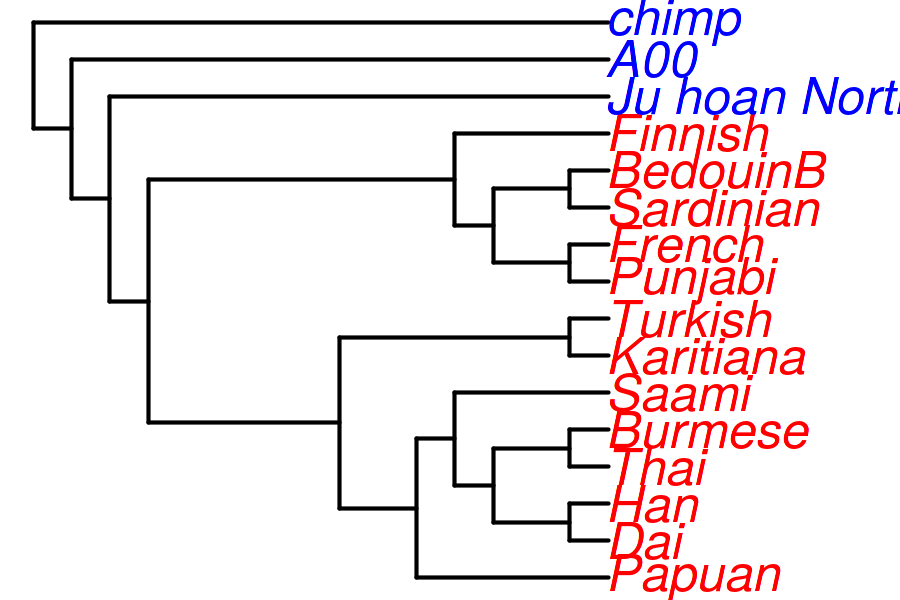

In [5]:
set_dim(3, 2)

aln <- read.phyDat(here("data/fasta/modern_full_merged_var.fa"), format = "fasta")
aln$ustishim <- NULL
aln$a00_1 <- NULL
aln$a00_2 <- NULL
aln$S_Dinka_1 <- NULL
aln$S_Gambian_1 <- NULL
aln$S_Yoruba_2 <- NULL
aln$S_Mandenka_1 <- NULL
aln$S_Mbuti_1 <- NULL

tree <- NJ(dist.ml(aln))

cols <- map_chr(tree$tip.label,
                ~ case_when(.x %in% ingroup ~ "red",
                            .x %in% outgroup ~ "blue",
                            .x == "chimp" ~ "blue",
                            TRUE ~ "black"))

tree$tip.label <-
    str_replace_all(tree$tip.label, "S_", "") %>%
    str_replace_all("_\\d$", "") %>%
    str_replace("a00", "A00")

rooted_tree <- root(tree, outgroup = c("chimp"), resolve.root = TRUE)

plot(rooted_tree, use.edge.length = FALSE, tip.color = cols, no.margin = TRUE)

## Process the genotypes into a table of human variable SNPs

In [6]:
filter_derived <- function(df) {
    # keep only variable sites (excluding chimp-unique variants)
    freqs <- select(df, -c(chrom, pos, REF, ALT, chimp)) %>% rowMeans(na.rm = TRUE)
    
    filter(df, freqs > 0 & freqs < 1) %>%
        mutate_at(vars(-one_of(c("chrom", "pos", "REF", "ALT", "chimp"))),
                  ~ as.integer(.x != chimp))
}

In [7]:
# Count derived alleles in an archaic sample
count_derived <- function(gt_derived, ind, outgroup, ingroup) {
    out_anc <- (rowMeans(gt_derived[, outgroup]) == 0)
    in_der <- (rowMeans(gt_derived[, ingroup]) == 1)

    alleles <- gt_derived[out_anc & in_der, ] %>% .[[ind]] %>% .[!is.na(.)]
    
    counts <- alleles %>% factor(levels = c(0, 1)) %>% table %>% as.data.frame
    names(counts) <- c("allele", "count")

    counts %>%
        mutate(allele = ifelse(allele == 0, "ancestral", "derived")) %>%
        spread(allele, count) %>%
        mutate(name = fix_name(ind),
               total = length(alleles)) %>%
        select(name, everything())
}

### Total number of informative non-African derived sites?

In [8]:
highcov_derived <- filter_derived(highcov)

out_anc <- (rowMeans(highcov_derived[, outgroup]) == 0)
in_der <- (rowMeans(highcov_derived[, ingroup]) == 1)

highcov_derived[out_anc & in_der, ] %>%
    filter(!is.na(chimp)) %>%
    nrow

[1] 199

### Count non-African derived SNPs in each archaic sample at sites with African ancestral alleles

In [9]:
counts <- future_map_dfr(c("spy1", "mez2", "den4", "den8", "elsidron2"), function(arch) {
    capture <- ifelse(arch == "elsidron2", "lippold", "full")

    gt <- read_genotypes(arch, capture, mindp = 3, maxdp = 0.98, var_only = TRUE)
    gt_derived <- filter_derived(gt)

    count_derived(gt_derived, arch, outgroup, ingroup)
})

In [10]:
counts %>% mutate(derived / total)

name,ancestral,derived,total,derived/total
<chr>,<int>,<int>,<int>,<dbl>
Spy 94a,9,1,10,0.1
Mezmaiskaya 2,148,0,148,0.0
Denisova 4,10,0,10,0.0
Denisova 8,71,0,71,0.0
El Sidrón 1253,26,0,26,0.0


### Sanity check - derived-allele counts in present-day SGDP samples

In [11]:
derived <- filter_derived(highcov)

In [12]:
counts_sgdp <- pops$name %>% future_map_dfr(~ count_derived(derived, .x, outgroup, ingroup))

In [13]:
counts_sgdp %>% mutate(derived / total)

name,ancestral,derived,total,derived/total
<chr>,<int>,<int>,<int>,<dbl>
Ust'-Ishim,0,196,196,1.0000000
S_BedouinB_1,0,199,199,1.0000000
S_Turkish_1,0,199,199,1.0000000
S_French_1,0,199,199,1.0000000
S_Burmese_1,0,199,199,1.0000000
S_Thai_1,0,199,199,1.0000000
S_Finnish_2,0,199,199,1.0000000
S_Sardinian_1,0,199,199,1.0000000
S_Han_2,0,199,199,1.0000000
